In [134]:
!pip install gurobipy
!pip install seaborn
!pip install numpy
import os
#Please change the location of license accordingly
os.environ['GRB_LICENSE_FILE'] = '/Users/weiyuandu/gurobi.lic'

In [135]:
class Data:
    customerNum = 0
    nodeNum = 0
    vehicleNum = 0
    capacity = 0
    corX = []
    corY = []
    demand = []
    serviceTime = []
    readyTime = []
    dueTime = []
    distanceMatrix = [[]]


def readData(path, customerNum):
    data = Data()
    data.customerNum = customerNum
    if customerNum is not None:
        data.nodeNum = customerNum + 2
    with open(path, 'r') as f:
        lines = f.readlines()
        count = 0
        for line in lines:
            count += 1
            if count == 5:
                line = line[:-1]
                s = re.split(r" +", line)
                data.vehicleNum = int(s[1])
                data.capacity = float(s[2])
            elif count >= 10 and (customerNum is None or count <= 10 + customerNum):
                line = line[:-1]
                s = re.split(r" +", line)
                data.corX.append(float(s[2]))
                data.corY.append(float(s[3]))
                data.demand.append(float(s[4]))
                data.readyTime.append(float(s[5]))
                data.dueTime.append(float(s[6]))
                data.serviceTime.append(float(s[7]))
    data.nodeNum = len(data.corX) + 1
    data.customerNum = data.nodeNum - 2
    # 回路
    data.corX.append(data.corX[0])
    data.corY.append(data.corY[0])
    data.demand.append(data.demand[0])
    data.readyTime.append(data.readyTime[0])
    data.dueTime.append(data.dueTime[0])
    data.serviceTime.append(data.serviceTime[0])
    # 计算距离矩阵
    data.distanceMatrix = np.zeros((data.nodeNum, data.nodeNum))
    for i in range(data.nodeNum):
        for j in range(i + 1, data.nodeNum):
            distance = math.sqrt((data.corX[i] - data.corX[j]) ** 2 + (data.corY[i] - data.corY[j]) ** 2)
            data.distanceMatrix[i][j] = data.distanceMatrix[j][i] = distance
    return data

In [136]:
class Solution:
    ObjVal = 0
    X = [[]]
    S = [[]]
    routes = [[]]
    routeNum = 0

    def __init__(self, data, model):
        self.ObjVal = model.ObjVal
        # X_ijk
        self.X = [[([0] * data.vehicleNum) for _ in range(data.nodeNum)] for _ in range(data.nodeNum)]
        # S_ik
        self.S = [([0] * data.vehicleNum) for _ in range(data.nodeNum)]
        # routes
        self.routes = []


def getSolution(data, model):
    solution = Solution(data, model)
    for m in model.getVars():
        split_arr = re.split(r"_", m.VarName)
        if split_arr[0] == 'X' and m.x > 0.5:
            solution.X[int(split_arr[1])][int(split_arr[2])][int(split_arr[3])] = m.x
        elif split_arr[0] == 'S' and m.x > 0.5:
            solution.S[int(split_arr[1])][int(split_arr[2])] = m.x
    for k in range(data.vehicleNum):
        i = 0
        subRoute = []
        subRoute.append(i)
        finish = False
        while not finish:
            for j in range(data.nodeNum):
                if solution.X[i][j][k] > 0.5:
                    subRoute.append(j)
                    i = j
                    if j == data.nodeNum - 1:
                        finish = True
        if len(subRoute) >= 3:
            subRoute[-1] = 0
            solution.routes.append(subRoute)
            solution.routeNum += 1
    return solution


def plot_solution(solution, customer_num):
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"{data_type} : {customer_num} Customers")
    plt.scatter(data.corX[0], data.corY[0], c='blue', alpha=1, marker=',', linewidths=3, label='depot')  # 起点
    plt.scatter(data.corX[1:-1], data.corY[1:-1], c='black', alpha=1, marker='o', linewidths=3,
                label='customer')  # 普通站点

    for k in range(solution.routeNum):
        for i in range(len(solution.routes[k]) - 1):
            a = solution.routes[k][i]
            b = solution.routes[k][i + 1]
            x = [data.corX[a], data.corX[b]]
            y = [data.corY[a], data.corY[b]]
            plt.plot(x, y, 'k', linewidth=1)
    plt.grid(False)
    plt.legend(loc='best')
    plt.show()


def print_solution(solution, data):
    for index, subRoute in enumerate(solution.routes):
        distance = 0
        load = 0
        for i in range(len(subRoute) - 1):
            distance += data.distanceMatrix[subRoute[i]][subRoute[i + 1]]
            load += data.demand[subRoute[i]]
        print(f"Route-{index + 1} : {subRoute} , distance: {distance} , load: {load}")


def solve(data):
    # 声明模型
    model = Model("VRPTW")
    # 模型设置
    # 关闭输出
    model.setParam('OutputFlag', 0)
    # 定义变量
    X = [[[[] for _ in range(data.vehicleNum)] for _ in range(data.nodeNum)] for _ in range(data.nodeNum)]
    S = [[[] for _ in range(data.vehicleNum)] for _ in range(data.nodeNum)]
    for i in range(data.nodeNum):
        for k in range(data.vehicleNum):
            S[i][k] = model.addVar(data.readyTime[i], data.dueTime[i], vtype=GRB.CONTINUOUS, name=f'S_{i}_{k}')
            for j in range(data.nodeNum):
                X[i][j][k] = model.addVar(vtype=GRB.BINARY, name=f"X_{i}_{j}_{k}")
    # 目标函数
    obj = LinExpr(0)
    for i in range(data.nodeNum):
        for j in range(data.nodeNum):
            if i != j:
                for k in range(data.vehicleNum):
                    obj.addTerms(data.distanceMatrix[i][j], X[i][j][k])
    model.setObjective(obj, GRB.MINIMIZE)
    # 约束1：车辆只能从一个点到另一个点
    for i in range(1, data.nodeNum - 1):
        expr = LinExpr(0)
        for j in range(data.nodeNum):
            if i != j:
                for k in range(data.vehicleNum):
                    if i != 0 and i != data.nodeNum - 1:
                        expr.addTerms(1, X[i][j][k])
        model.addConstr(expr == 1)
    # 约束2：车辆必须从仓库出发
    for k in range(data.vehicleNum):
        expr = LinExpr(0)
        for j in range(1, data.nodeNum):
            expr.addTerms(1, X[0][j][k])
        model.addConstr(expr <= 1)
    # 约束3：车辆经过一个点就必须离开一个点
    for k in range(data.vehicleNum):
        for h in range(1, data.nodeNum - 1):
            expr1 = LinExpr(0)
            expr2 = LinExpr(0)
            for i in range(data.nodeNum):
                if h != i:
                    expr1.addTerms(1, X[i][h][k])
            for j in range(data.nodeNum):
                if h != j:
                    expr2.addTerms(1, X[h][j][k])
            model.addConstr(expr1 == expr2)
    # 约束4：车辆最终返回仓库
    for k in range(data.vehicleNum):
        expr = LinExpr(0)
        for i in range(data.nodeNum - 1):
            expr.addTerms(1, X[i][data.nodeNum - 1][k])
        model.addConstr(expr == 1)
    # 约束5：车辆容量约束
    for k in range(data.vehicleNum):
        expr = LinExpr(0)
        for i in range(1, data.nodeNum - 1):
            for j in range(data.nodeNum):
                if i != 0 and i != data.nodeNum - 1 and i != j:
                    expr.addTerms(data.demand[i], X[i][j][k])
        model.addConstr(expr <= data.capacity)
    # 约束6：时间窗约束
    for k in range(data.vehicleNum):
        for i in range(data.nodeNum):
            for j in range(data.nodeNum):
                if i != j:
                    model.addConstr(S[i][k] + data.distanceMatrix[i][j] - S[j][k] <= M - M * X[i][j][k])
    # 记录求解开始时间
    start_time = time.time()
    # 求解
    model.optimize()
    if model.status == GRB.OPTIMAL:
        print("-" * 20, "Solved Successfully", '-' * 20)
        # 输出求解总用时
        print(f"Solve Time: {time.time() - start_time} s")
        print(f"Total Travel Distance: {model.ObjVal}")
        solution = getSolution(data, model)
        plot_solution(solution, data.customerNum)
        print_solution(solution, data)
    else:
        print("此题无解")

-------------------- Problem Information --------------------
Data Type: c101
Node Num: 22
Customer Num: 20
Vehicle Num: 25
Vehicle Capacity: 200.0
-------------------- Solved Successfully --------------------
Solve Time: 0.5928797721862793 s
Total Travel Distance: 160.81590595966603
-------------------- Solved Successfully --------------------
Solve Time: 0.5928797721862793 s
Total Travel Distance: 160.81590595966603


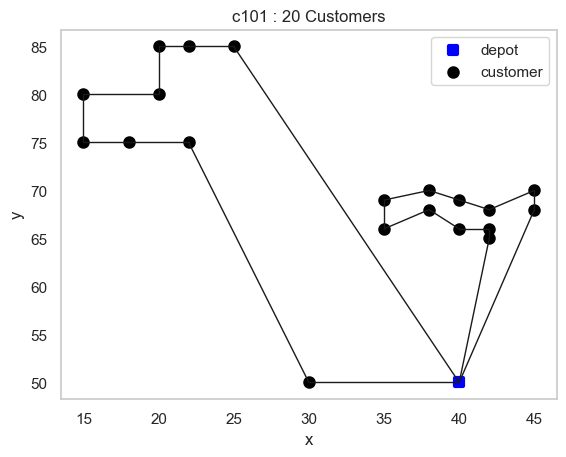

Route-1 : [0, 20, 13, 17, 18, 19, 15, 16, 14, 12, 0] , distance: 101.32767502613292 , load: 200.0
Route-2 : [0, 5, 3, 7, 8, 10, 11, 9, 6, 4, 2, 1, 0] , distance: 59.48823093353308 , load: 160.0


In [137]:
if __name__ == '__main__':
    # 哪个数据集
    data_type = "c101"
    # 数据集路径
    data_path = f'../data/solomon/{data_type}.txt'
    # 顾客个数设置（从上往下读取完 customerNum 个顾客为止，例如c101文件中有100个顾客点，
    # 但是跑100个顾客点太耗时了，设置这个数是为了只选取一部分顾客点进行计算，用来快速测试算法）
    # 如果想用完整的顾客点进行计算，设置为None即可
    customerNum = 20
    # 一个很大的正数
    M = 10000000
    # 读取数据
    data = readData(data_path, customerNum)
    # 输出相关数据
    print("-" * 20, "Problem Information", '-' * 20)
    print(f'Data Type: {data_type}')
    print(f'Node Num: {data.nodeNum}')
    print(f'Customer Num: {data.customerNum}')
    print(f'Vehicle Num: {data.vehicleNum}')
    print(f'Vehicle Capacity: {data.capacity}')
    # 建模求解
    solve(data)